In [176]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style='ticks', context='talk')
# fix slow autocomplete
%config Completer.use_jedi = False
pd.options.display.max_columns=300
pd.options.display.max_rows=300

params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

In [177]:
from patchseq_utils import analysis as utils, plotting as plot
from patchseq_utils import l1_load, util, lims
from importlib import reload
reload(l1_load)
reload(util)
from patchseq_utils.util import *
from patchseq_utils.l1_load import *

/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/l1_load.py:131: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  human_df['primary_ephys'] = human_df.eval('collaborator=="AIBS" & failed_fx_long_squares==False')


In [178]:
# load L1 dataset
# human_df = human_df.loc[pd.read_csv(projectdir/"human_l1_dataset_strict.csv", index_col=0).index]
# mouse_df = mouse_df.loc[pd.read_csv(projectdir/"mouse_l1_dataset_strict.csv", index_col=0).index]

# Mice

In [179]:
donor = 'donor_name'
mouse_all = pd.concat([mouse_df,
                      pd.read_csv(projectdir/"mansvelder_tea_2022_09_16.csv", index_col=0)],
                     sort=False)
mice = lims.get_donor_info(mouse_all[donor].unique()).set_index('name')

mice['full_genotype'] = mice['full_genotype'].str.replace('/wt','')

In [180]:
mouse_all.query("failed_fx_long_squares==False").cortical_area_ccf.value_counts()

VISp      220
VISpm      25
VISl       15
TEa         8
VISpor      3
VISli       3
VISal       2
VISpl       1
Name: cortical_area_ccf, dtype: int64

In [181]:
def summarize(df):
    results = {
        'cell count': df.shape[0],
        'morphology count': df.query("has_morph").shape[0],
        'primary (VIS) ephys count': 
        df.query("failed_qc==False").shape[0],
        'secondary (TEa) ephys count': 
        df.query("failed_fx_long_squares==False").shape[0],
        'brain areas': ', '.join(list(df['cortical_area_ccf'].unique())),
        # 'hemisphere': ', '.join(list(df['hemisphere'].fillna('').unique())),
    }
    return pd.Series(results)


In [182]:
mice_data = mice.join(mouse_all.groupby('donor_name').apply(summarize)).drop(
    columns=['id', 'species', 'medical_condition'])
mice_data.head()


,full_genotype,sex,age,cell count,morphology count,primary (VIS) ephys count,secondary (TEa) ephys count,brain areas
name,,,,,,,,
Ndnf-IRES2-dgCre;Ai14-355224,Ndnf-IRES2-dgCre;Ai14(RCL-tdT),M,P47,1,1,1,1,VISp
Sncg-IRES2-FlpO-neo;Ai65F-456104,Sncg-IRES2-FlpO-neo;Ai65F,M,P60,3,1,2,3,VISp
Ndnf-IRES2-dgCre;Slc32a1-IRES2-FlpO;Ai65-391467,Ndnf-IRES2-dgCre;Slc32a1-IRES2-FlpO;Ai65(RCFL-...,F,P51,3,0,3,3,"VISp, VISl"
Ndnf-IRES2-dgCre;Ai14-355222,Ndnf-IRES2-dgCre;Ai14(RCL-tdT),M,P45,2,0,1,2,VISp
Vip-IRES-Cre;Ai14-479202,Vip-IRES-Cre;Ai14(RCL-tdT),F,P60,1,0,1,1,VISl


# Human

In [183]:
donor = 'donor_name'
donors = lims.get_donor_info(human_df[donor].unique()).set_index('name')

donors['medical_condition'].value_counts(dropna=False)

disease categories - epilepsy         42
disease categories - tumor            34
disease categories - hydrocephalus     4
Tumor status - primary                 3
Epileptiform Events                    1
Name: medical_condition, dtype: int64

In [184]:
def condition(x):
    if pd.isna(x):
        return x
    elif 'tumor' in x.lower():
        return 'tumor'
    elif 'epilep' in x.lower():
        return 'epilepsy'
    elif 'hydrocephalus' in x:
        return 'hydrocephalus'
    else:
        return x
    
def epileptic(x):
    if pd.isna(x):
        return x
    elif 'epilep' in x.lower():
        return 'epileptic'
    else:
        return 'non-epileptic'
    

In [185]:
def summarize(df):
    results = {
        'cell count': df.shape[0],
        'morphology count': df.query("has_morph").shape[0],
        'primary ephys count': 
        df.query("collaborator=='AIBS' & failed_fx_long_squares==False").shape[0],
        'holdout ephys count': 
        df.query("collaborator!='AIBS' & failed_fx_long_squares==False").shape[0],
        'brain areas': ', '.join(list(df['structure'].fillna('CeG').unique())),
        'hemisphere': df["hemisphere"].values[0],
    }
    return pd.Series(results)


In [186]:
donors['condition'] = donors['medical_condition'].map(condition)
donors['epileptic'] = donors['medical_condition'].map(epileptic)
human_df = human_df.join(donors, on=donor, rsuffix='_r')

epilepsy_palette = {'epileptic': 'red', 'non-epileptic':'blue'}

In [187]:
donors = donors.join(human_df.groupby('donor').apply(summarize)).drop(
    columns=['id', 'full_genotype', 'species', 'medical_condition'])
donors.head()


,sex,age,condition,epileptic,cell count,morphology count,primary ephys count,holdout ephys count,brain areas,hemisphere
name,,,,,,,,,,
H16.06.012,M,83 yrs,tumor,non-epileptic,1.0,1.0,1.0,0.0,MFG,NaN
H17.03.002,M,61 yrs,epilepsy,epileptic,3.0,1.0,3.0,0.0,MTG,right
H17.03.009,M,18 yrs,epilepsy,epileptic,3.0,1.0,3.0,0.0,MTG,right
H17.03.010,F,38 yrs,epilepsy,epileptic,2.0,0.0,2.0,0.0,MTG,left
H17.06.012,M,23 yrs,epilepsy,epileptic,1.0,0.0,1.0,0.0,MTG,right


# Brain area

In [188]:
human_df.loc[lambda df: df.donor_name=='H18.03.003', 'structure'] = 'CeG'
human_df.loc[lambda df: df.donor_name=='H22.26.404', 'structure']= 'SFG'

In [189]:
def lobe(x):
    if any((y in x for y in ['Tem', 'TG', 'PLP', 'PRG', 'PaCG'])): 
        return 'TemL'
    elif any((y in x for y in ['Fro', 'OrG', 'FG'])): 
        return 'FroL'
    elif any((y in x for y in ['Occ', 'OG'])): 
        return 'OccL'
    elif any((y in x for y in ['AnG', 'Par'])): 
        return 'ParL'
    else:
        return None
human_df['cortical_lobe'] = human_df['structure'].fillna('').map(lobe)
human_df.query('has_morph')['cortical_lobe'].value_counts(dropna=False)
# exclude SPL (parietal) and OccL??

TemL    56
FroL    15
OccL     3
None     2
ParL     2
Name: cortical_lobe, dtype: int64

In [190]:
# query hack for missing values x!=x
x = human_df.query("((collaborator=='AIBS' & failed_fx_long_squares==False) | has_morph) & structure!=structure")[
    ['cell_name', 'donor_name','slice', cluster, 'layer', 'target_layer', 'has_morph', 'collaborator', 'roi', 'condition']
]
# x.to_csv('need_pin.csv')
x

,cell_name,donor_name,slice,t-type,layer,target_layer,has_morph,collaborator,roi,condition
spec_id,,,,,,,,,,


In [191]:
# query hack for missing values x!=x
x = human_df.query("((collaborator!='AIBS' & failed_fx_long_squares==False)) & structure!=structure")[
    ['cell_name', 'donor_name','slice', cluster, 'layer', 'target_layer', 'has_morph', 'collaborator', 'roi', 'condition']
]

x = x.groupby('slice').first()
# x.to_csv('../ephys_only_pinning.csv')
x

,cell_name,donor_name,t-type,layer,target_layer,has_morph,collaborator,roi,condition
slice,,,,,,,,,


## proportions

In [192]:
import scipy.stats as stats

def df_fisher(df, cluster, meta, cluster_name, test=stats.fisher_exact):
    ct = pd.crosstab(df[meta], df[cluster]==cluster_name)
    out = test(ct)
    
    return out.pvalue if hasattr(out, 'pvalue') else out[1]

def fisher_test_all(df, cluster, meta, test=stats.fisher_exact):
    df = df.dropna(subset=[cluster])
    names = df[cluster].unique()
    return pd.Series({cluster_name: df_fisher(df, cluster, meta, cluster_name, test) 
           for cluster_name in names}).sort_values()

In [193]:
df = human_df.query("layer=='1' & collaborator=='AIBS'")
group_col = 'structure'
df[group_col].value_counts(dropna=False)

MTG      126
TemL      24
ITG       22
SFG       13
MFG        5
STG        4
PRG        3
IFGtr      3
CeG        2
LOrG       1
OccL       1
SPL        1
Name: structure, dtype: int64

In [194]:
data = pd.get_dummies(df, columns=[group_col])

In [195]:
fisher_test_all(data, 'homology_type', 'structure_MTG')

LAMP5     0.024934
MC4R      0.047427
PAX6      0.263020
other     0.579569
L1 VIP    0.788824
dtype: float64

In [196]:
pd.crosstab(data['structure_MTG'], data['homology_type'])

homology_type,LAMP5,MC4R,PAX6,L1 VIP,other
structure_MTG,,,,,
0,41,7,11,5,7
1,48,25,27,10,8


In [197]:
fisher_test_all(data, 'homology_type', 'structure_ITG')

PAX6      0.257688
LAMP5     0.261494
other     0.688103
MC4R      0.770665
L1 VIP    1.000000
dtype: float64

In [198]:
fisher_test_all(data, 'homology_type', 'structure_TemL')

LAMP5     0.020921
MC4R      0.027576
PAX6      0.577572
other     0.675215
L1 VIP    1.000000
dtype: float64

In [199]:
pd.crosstab(data['structure_TemL'], data['homology_type'])

homology_type,LAMP5,MC4R,PAX6,L1 VIP,other
structure_TemL,,,,,
0,74,32,35,14,13
1,15,0,3,1,2


## Ephys

In [243]:
df = human_df.query("l1_type & collaborator=='AIBS' & failed_fx_long_squares==False")
group_col = 'structure'
order = ['ITG','MTG','MFG','SFG']
data = subset_data(df, ephys_features, cluster=group_col, ephys_frac_min=0, cluster_min=5).query("structure!='TemL'")
data[group_col] = pd.Categorical( data[group_col], categories=order, ordered=True)
data[group_col].value_counts()

MTG    115
ITG     23
SFG     14
MFG      5
Name: structure, dtype: int64

In [244]:
features = subset_features(data, ephys_features, complete_frac=0.5)
# features = ephys_features
res = utils.run_kw_dunn(data, features, group_col)
# res.to_csv(figdir/'supp_tables'/'md_region_ephys.csv')
md_region_ephys = res
res.head(20)

,KW_H,pval,epsilon2,pval_fdr,pairs,ipairs,sig_pair_count
feature,,,,,,,
sag_peak_t,19.786462,0.000188,0.126836,0.015600,"[(ITG, SFG), (MTG, MFG), (MTG, SFG), (MFG, SFG)]","[03, 12, 13, 23]",4.0
downstroke_rheo,16.113806,0.001075,0.103294,0.028912,"[(ITG, MTG), (ITG, MFG), (MTG, SFG), (MFG, SFG)]","[01, 02, 13, 23]",4.0
downstroke_ramp,15.961781,0.001155,0.102979,0.028912,"[(ITG, MTG), (ITG, MFG), (MTG, SFG), (MFG, SFG)]","[01, 02, 13, 23]",4.0
input_resistance_ss,15.563341,0.001393,0.101061,0.028912,"[(ITG, SFG), (MTG, MFG), (MFG, SFG)]","[03, 12, 23]",3.0
avg_rate_max,15.062039,0.001764,0.096552,0.029289,"[(ITG, MTG), (ITG, SFG), (MTG, MFG), (MFG, SFG)]","[01, 03, 12, 23]",4.0
threshold_i_ramp,14.107106,0.002763,0.091014,0.038221,"[(MTG, MFG)]",[12],1.0
width_suprathresh_ramp,12.541431,0.005741,0.080912,0.053236,NaN,NaN,NaN
downstroke_hero,12.389682,0.006161,0.079421,0.053236,NaN,NaN,NaN
upstroke_short_square,12.043866,0.007234,0.078207,0.053236,NaN,NaN,NaN


In [245]:
corr = data[features].corr(method='spearman')
feat = utils.select_distinct(res.index, corr, nfeat=4, threshold=0.7)
feat

['sag_peak_t', 'downstroke_rheo', 'input_resistance_ss', 'avg_rate_max']

In [246]:
res.loc[feat]

,KW_H,pval,epsilon2,pval_fdr,pairs,ipairs,sig_pair_count
feature,,,,,,,
sag_peak_t,19.786462,0.000188,0.126836,0.015600,"[(ITG, SFG), (MTG, MFG), (MTG, SFG), (MFG, SFG)]","[03, 12, 13, 23]",4.0
downstroke_rheo,16.113806,0.001075,0.103294,0.028912,"[(ITG, MTG), (ITG, MFG), (MTG, SFG), (MFG, SFG)]","[01, 02, 13, 23]",4.0
input_resistance_ss,15.563341,0.001393,0.101061,0.028912,"[(ITG, SFG), (MTG, MFG), (MFG, SFG)]","[03, 12, 23]",3.0
avg_rate_max,15.062039,0.001764,0.096552,0.029289,"[(ITG, MTG), (ITG, SFG), (MTG, MFG), (MFG, SFG)]","[01, 03, 12, 23]",4.0


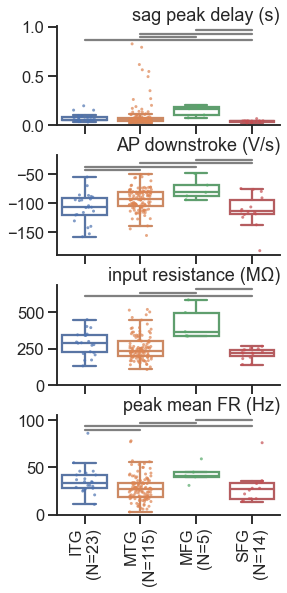

In [247]:
feat = ['sag_peak_t', 'downstroke_rheo', 'input_resistance_ss', 'avg_rate_max']
labels = ['sag peak delay (s)', 'AP downstroke (V/s)', 
          'input resistance (MΩ)', 'peak mean FR (Hz)']
utils.plot_boxplot_multiple(data, feat, group_col, labels=labels, test='dunn',
                       space=0.3, pad_title=5, figsize=(4,9))
save_plot_multiple(figdir/"s6_region_ephys", ['svg'])

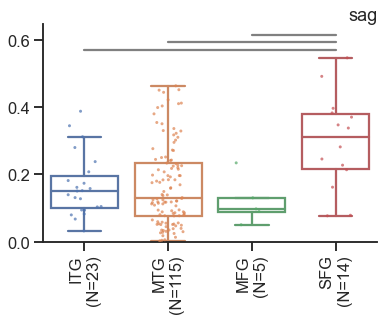

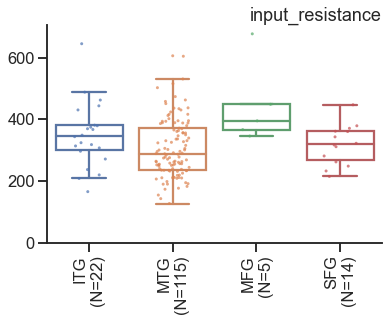

In [210]:
features = [
    'sag',
    'input_resistance'
]
for f in features:
    utils.plot_box_cluster_feature(data, f, group_col, test='dunn')

## Morpho

In [248]:
df = human_df.query("l1_type")
group_col = 'structure'
data = subset_data(df, morph_features, cluster=group_col, ephys_frac_min=0, cluster_min=5).query("structure!='TemL'")
# order = ['ITG','MTG','STG','MFG','SFG']
# data[group_col] = pd.Categorical( data[group_col], categories=order, ordered=True)
data[group_col].value_counts()

MTG    31
ITG     8
SFG     7
Name: structure, dtype: int64

In [249]:
features = morph_features
res = utils.run_kw_dunn(data, features, group_col)
# res.to_csv(figdir/'supp_tables'/'md_region_morpho.csv')
md_region_morpho = res
res.head(20)

,KW_H,pval,epsilon2,pval_fdr
feature,,,,
axon_exit_theta,10.893485,0.004310,0.242077,0.093639
basal_dendrite_extent_y,9.948392,0.006914,0.221075,0.093639
basal_dendrite_mean_contraction,9.462194,0.008817,0.210271,0.093639
basal_dendrite_max_euclidean_distance,9.439084,0.008919,0.209757,0.093639
basal_dendrite_max_path_distance,9.232555,0.009890,0.205168,0.093639
basal_dendrite_total_length,9.016757,0.011016,0.200372,0.093639
basal_dendrite_frac_intersect_axon,8.597882,0.013583,0.191064,0.098961
axon_soma_percentile_x,7.846485,0.019777,0.174366,0.126077
basal_dendrite_total_surface_area,7.424257,0.024425,0.164983,0.138411


In [250]:
corr = data[features].corr(method='spearman')
feat = utils.select_distinct(res.index, corr, nfeat=4, threshold=0.7)
feat

['axon_exit_theta',
 'basal_dendrite_extent_y',
 'basal_dendrite_mean_contraction',
 'basal_dendrite_frac_intersect_axon']

In [251]:
res.loc[feat]

,KW_H,pval,epsilon2,pval_fdr
feature,,,,
axon_exit_theta,10.893485,0.004310,0.242077,0.093639
basal_dendrite_extent_y,9.948392,0.006914,0.221075,0.093639
basal_dendrite_mean_contraction,9.462194,0.008817,0.210271,0.093639
basal_dendrite_frac_intersect_axon,8.597882,0.013583,0.191064,0.098961


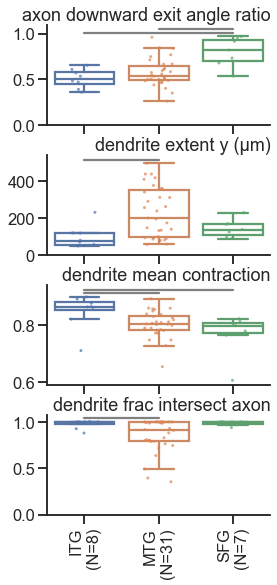

In [252]:
feat = ['axon_exit_theta',
 'basal_dendrite_extent_y',
 'basal_dendrite_mean_contraction',
 'basal_dendrite_frac_intersect_axon']
labels = [feature_name(x) for x in feat]
labels[0] = 'axon downward exit angle ratio'
labels[1] += ' (μm)'
utils.plot_boxplot_multiple(data, feat, group_col, labels=labels, test='dunn',
                       space=0.3, pad_title=5, figsize=(4,9))
save_plot_multiple(figdir/"s6_region_morpho", ['svg'])

In [253]:
df = human_df.query("l1_type")
group_col = 'cortical_lobe'
data = subset_data(df, morph_features, cluster=group_col, ephys_frac_min=0, cluster_min=5)#.query("structure!='TemL'")
# order = ['ITG','MTG','STG','MFG','SFG']
# data[group_col] = pd.Categorical( data[group_col], categories=order, ordered=True)
data[group_col].value_counts()

TemL    52
FroL    13
Name: cortical_lobe, dtype: int64

In [254]:
features = morph_features
res = utils.run_kw_dunn(data, features, group_col)
# res.to_csv(figdir/'supp_tables'/'md_region_morpho.csv')
res.head(20)

,KW_H,pval,epsilon2,pval_fdr
feature,,,,
soma_aligned_dist_from_pia,6.629640,0.010030,0.103588,0.405889
axon_exit_theta,5.811996,0.015917,0.090812,0.405889
basal_dendrite_mean_diameter,4.974718,0.025720,0.077730,0.437247
basal_dendrite_num_branches,4.242613,0.039421,0.066291,0.502623
basal_dendrite_calculate_number_of_stems,3.392708,0.065485,0.053011,0.517666
axon_max_branch_order,3.209563,0.073209,0.050149,0.517666
axon_emd_with_basal_dendrite,2.798279,0.094366,0.043723,0.517666
axon_num_branches,2.771881,0.095933,0.043311,0.517666
basal_dendrite_max_euclidean_distance,2.743679,0.097640,0.042870,0.517666


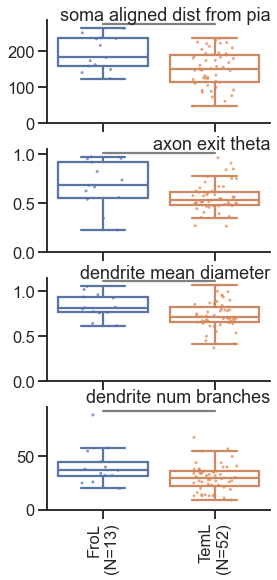

In [255]:
corr = data[features].corr(method='spearman')
feat = utils.select_distinct(res.index, corr, nfeat=4, threshold=0.7)
utils.plot_boxplot_multiple(data, feat, group_col, labels=feature_name, test='dunn', figsize=(4,9))

# medical condition

## Proportions

In [220]:
group_col = 'epileptic'
data = df.query("layer=='1'")
fisher_test_all(data, 'homology_type', group_col)

L1 VIP    0.014267
LAMP5     0.051099
PAX6      0.497156
other     0.624379
MC4R      0.856193
dtype: float64

In [221]:
pd.crosstab(data[group_col], df[cluster]=='VIP TSPAN12')

t-type,False,True
epileptic,,
epileptic,144,8
non-epileptic,67,12


In [222]:
data = subset_data(df.query("failed_fx_long_squares==False"),
                   ephys_features, cluster=group_col, ephys_frac_min=0, cluster_min=5)
data[group_col].value_counts(dropna=False)

epileptic        155
non-epileptic     70
Name: epileptic, dtype: int64

## ephys

In [322]:
data = human_df.query("l1_type & collaborator=='AIBS' & failed_fx_long_squares==False")
group_col = 'epileptic'
data[group_col].value_counts(dropna=False)

epileptic        152
non-epileptic     42
Name: epileptic, dtype: int64

In [323]:
features = subset_features(data, ephys_features, complete_frac=0.4)
res = utils.run_twosamp(data, features, group_col, fdr_method='fdr_bh')
# res.to_csv(figdir/'supp_tables'/'md_medical_ephys.csv')
md_medical_ephys = res
res.head(20)

,pval_mw,mw_r,roc_auc,pval_t,cohens_d,nobs,pval_t_fdr,pval_mw_fdr
feature,,,,,,,,
width_ramp,0.028572,0.221224,0.610612,0.328559,0.171339,193,0.934232,0.919477
width_suprathresh_ramp,0.046134,0.201514,0.600757,0.378426,0.154501,193,0.934232,0.919477
postap_slope_ramp,0.050765,0.197414,0.598707,0.034596,0.368864,193,0.661132,0.919477
width_rheo,0.055428,0.193296,0.596648,0.068952,0.317736,194,0.792947,0.919477
width_suprathresh_rheo,0.060285,0.189536,0.594768,0.087764,0.298422,194,0.827017,0.919477
sag_tau,0.063391,0.216000,0.608000,0.050304,0.393461,156,0.661132,0.919477
phase_peak_chirp,0.072170,0.279514,0.639757,0.007011,0.714185,82,0.644986,0.919477
downstroke_ramp,0.114406,0.159571,0.579786,0.160185,0.245968,193,0.880111,0.919477
width_suprathresh_short_square,0.117677,0.159586,0.579793,0.325791,0.173961,192,0.934232,0.919477


In [324]:
corr = data[features].corr(method='spearman')
feat = utils.select_distinct(res.index, corr, nfeat=4, threshold=0.7)
feat

['width_ramp', 'postap_slope_ramp', 'sag_tau', 'phase_peak_chirp']

In [325]:
res.loc[feat]

,pval_mw,mw_r,roc_auc,pval_t,cohens_d,nobs,pval_t_fdr,pval_mw_fdr
feature,,,,,,,,
width_ramp,0.028572,0.221224,0.610612,0.328559,0.171339,193,0.934232,0.919477
postap_slope_ramp,0.050765,0.197414,0.598707,0.034596,0.368864,193,0.661132,0.919477
sag_tau,0.063391,0.216000,0.608000,0.050304,0.393461,156,0.661132,0.919477
phase_peak_chirp,0.072170,0.279514,0.639757,0.007011,0.714185,82,0.644986,0.919477


In [326]:
data.loc[lambda df: df['width_ramp'] > 2e-3, 'width_ramp'] = np.nan

In [327]:
reload(utils)

<module 'patchseq_utils.analysis' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/analysis.py'>

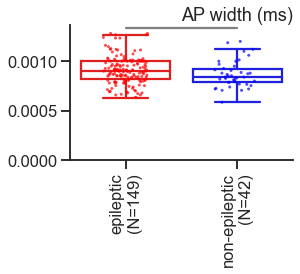

In [332]:
fig, ax = plt.subplots( figsize=(4,2.5))
utils.plot_box_cluster_feature(data, 'width_ramp', group_col, label='AP width (ms)', 
                               test='mannwhitney', #test_label='stars', pad_title=10,
                               ax=ax, palette=epilepsy_palette
                               )
save_plot_multiple(figdir/"s6_medical_ephys", ['svg'])

### MTG only

In [319]:
data = human_df.query("primary_ephys & structure=='MTG' & homology_type=='LAMP5'")
group_col = 'epileptic'
data[group_col].value_counts(dropna=False)

epileptic        42
non-epileptic     9
Name: epileptic, dtype: int64

In [320]:
res = utils.run_twosamp(data, features, group_col, fdr_method='fdr_bh').sort_values('mw_r', ascending=False)
res.head()

,pval_mw,mw_r,roc_auc,pval_t,cohens_d,nobs,pval_t_fdr,pval_mw_fdr
feature,,,,,,,,
tau,0.005041,0.603175,0.801587,0.020787,0.847275,51,0.474190,0.392449
latency_hero,0.011322,0.544974,0.772487,0.052907,0.715201,51,0.489581,0.392449
width_suprathresh_short_square,0.023421,0.511905,0.755952,0.229665,0.471812,50,0.780133,0.392449
sag,0.020876,0.497354,0.748677,0.025178,0.821844,51,0.474190,0.392449
sag_area,0.021321,0.494709,0.747354,0.029763,0.798996,51,0.474190,0.392449


In [321]:
res.loc[feat]

,pval_mw,mw_r,roc_auc,pval_t,cohens_d,nobs,pval_t_fdr,pval_mw_fdr
feature,,,,,,,,
width_ramp,0.235203,0.257453,0.628726,0.286124,0.400429,50,0.780133,0.618248
postap_slope_ramp,0.919545,0.024390,0.512195,0.696125,0.147378,50,0.875180,0.995272
sag_tau,0.292559,0.282828,0.641414,0.309075,0.463319,39,0.780133,0.710992
phase_peak_chirp,0.739353,0.109091,0.554545,0.471698,0.372309,27,0.780133,0.938044


### Interaction

In [230]:
data = human_df.query("l1_type & collaborator=='AIBS' & failed_fx_long_squares==False")
groups='homology_type'
compare='epileptic'
data.groupby(groups)[compare].value_counts(dropna=False)

homology_type  epileptic    
LAMP5          epileptic        80
               non-epileptic    16
MC4R           epileptic        29
               non-epileptic     6
PAX6           epileptic        22
               non-epileptic    11
L1 VIP         epileptic         8
               non-epileptic     7
other          epileptic        13
               non-epileptic     2
Name: epileptic, dtype: int64

In [231]:
features = subset_features(data, ephys_features, complete_frac=0.4)
res = utils.run_species_subclass_stats(data, features, compare=compare, group_var=groups, anova_type=1, 
                                       compare_first=False, )
res.head(10)

,eta_p_epileptic,pval_epileptic,pval_homology_type:epileptic,rsquared,interaction,sig_groups,PAX6,LAMP5,MC4R,other,L1 VIP,auc_PAX6,auc_LAMP5,auc_MC4R,auc_other,auc_L1 VIP
feature,,,,,,,,,,,,,,,,
low_freq_impedance_chirp,0.664278,8.953790e-17,2.483365e-54,0.983689,True,,0.943279,0.965180,0.923077,0.571429,0.666667,0.525000,0.506757,0.541667,0.700000,1.000
phase_peak_chirp,0.180051,7.495903e-03,3.632748e-09,0.644651,True,,0.170940,0.456402,0.087912,0.571429,0.666667,0.750000,0.587838,0.916667,0.700000,1.000
phase_low_chirp,0.124817,6.119920e-02,1.727562e-21,0.845696,True,,0.621601,0.050539,0.439560,0.380952,0.666667,0.600000,0.722973,0.708333,0.800000,1.000
input_resistance_ss,0.039604,1.538889e-01,6.593739e-01,0.197671,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_inductive_phase_chirp,0.034811,6.818591e-01,2.014204e-12,0.698302,True,,0.921146,0.183184,0.205056,0.070508,0.666667,0.525000,0.645270,0.791667,1.000000,1.000
first_isi_inv_rheo,0.032935,5.103528e-01,6.415248e-02,0.290627,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
isi_cv_hero,0.029329,2.913376e-01,2.483585e-01,0.180729,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
input_resistance,0.029283,2.913376e-01,9.997001e-01,0.241362,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sag,0.028012,2.913376e-01,2.133473e-01,0.660567,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## morpho

In [232]:
# data = human_df.query("l1_type & has_morph & condition!='hydrocephalus' & cortical_lobe=='TemL'")
# data = human_df.query("l1_type & has_morph & condition!='hydrocephalus' & homology_type!='L1 VIP'")
# data = human_df.query("l1_type & has_morph & condition!='hydrocephalus' & homology_type=='LAMP5' & layer=='1'")
# data = human_df.query("l1_type & has_morph & condition!='hydrocephalus' & collaborator=='AIBS'")
group_col = 'condition'

data = human_df.query("l1_type & has_morph & cortical_lobe=='TemL' & homology_type!='L1 VIP'")
data = human_df.query("l1_type & has_morph & cortical_lobe=='TemL' & homology_type=='LAMP5'")
data = human_df.query("l1_type & has_morph & structure=='MTG' & homology_type=='LAMP5'")
data = human_df.query("l1_type & has_morph")
group_col = 'epileptic'
data[group_col].value_counts(dropna=False)

epileptic        39
non-epileptic    32
Name: epileptic, dtype: int64

In [233]:
features = morph_features
res = utils.run_twosamp(data, features, group_col, fdr_method='fdr_bh').sort_values('mw_r', ascending=False)
# res.to_csv(figdir/'supp_tables'/'md_medical_morpho.csv')
md_medical_morpho = res
res.head(20)

,pval_mw,mw_r,roc_auc,pval_t,cohens_d,nobs,pval_t_fdr,pval_mw_fdr
feature,,,,,,,,
basal_dendrite_total_surface_area,0.000022,0.589744,0.794872,0.000053,0.925458,71,0.002719,0.001105
basal_dendrite_num_branches,0.000156,0.524840,0.762420,0.000166,0.869008,71,0.004237,0.003974
basal_dendrite_total_length,0.000348,0.496795,0.748397,0.000281,0.841057,71,0.004785,0.005916
axon_over_basal_dendrite_extent_x,0.001638,0.437500,0.718750,0.006876,0.639181,71,0.070135,0.020883
axon_frac_above_basal_dendrite,0.002587,0.416667,0.708333,0.009266,0.616548,71,0.071928,0.026383
axon_frac_intersect_basal_dendrite,0.008703,0.364583,0.682292,0.009873,0.611624,71,0.071928,0.073979
axon_bias_y,0.013615,0.342949,0.671474,0.056363,0.457272,71,0.261320,0.096423
basal_dendrite_mean_contraction,0.015476,0.336538,0.668269,0.017171,0.566863,71,0.109468,0.096423
basal_dendrite_extent_x,0.017016,0.331731,0.665865,0.004649,0.667672,71,0.059270,0.096423


In [234]:
corr = data[features].corr(method='spearman')
feat = utils.select_distinct(res.index, corr, nfeat=4, threshold=0.7)
feat

['basal_dendrite_total_surface_area',
 'basal_dendrite_num_branches',
 'axon_over_basal_dendrite_extent_x',
 'axon_frac_above_basal_dendrite']

In [235]:
res.loc[feat]

,pval_mw,mw_r,roc_auc,pval_t,cohens_d,nobs,pval_t_fdr,pval_mw_fdr
feature,,,,,,,,
basal_dendrite_total_surface_area,0.000022,0.589744,0.794872,0.000053,0.925458,71,0.002719,0.001105
basal_dendrite_num_branches,0.000156,0.524840,0.762420,0.000166,0.869008,71,0.004237,0.003974
axon_over_basal_dendrite_extent_x,0.001638,0.437500,0.718750,0.006876,0.639181,71,0.070135,0.020883
axon_frac_above_basal_dendrite,0.002587,0.416667,0.708333,0.009266,0.616548,71,0.071928,0.026383


In [236]:
feat = ['basal_dendrite_total_surface_area',
 'basal_dendrite_num_branches',
 'axon_over_basal_dendrite_extent_x',
 'axon_frac_above_basal_dendrite']
labels = [feature_name(x) for x in feat]
labels[0] += ' ($μm^2$)'

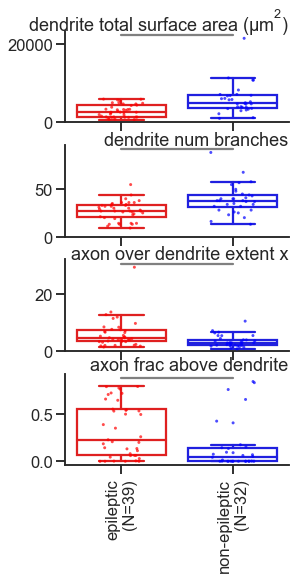

In [237]:
utils.plot_boxplot_multiple(data, feat, group_col, labels=labels, test='mannwhitney', figsize=(4,8), pairs='all',
                          palette=epilepsy_palette )
save_plot_multiple(figdir/"s6_medical_morph", ['svg'])

### MTG only

In [238]:
data = human_df.query("l1_type & has_morph & structure=='MTG' & homology_type=='LAMP5'")
group_col = 'epileptic'
data[group_col].value_counts(dropna=False)

epileptic        9
non-epileptic    3
Name: epileptic, dtype: int64

In [239]:
features = morph_features
res = utils.run_twosamp(data, features, group_col, fdr_method='fdr_bh').sort_values('mw_r', ascending=False)
res.head()

/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/analysis.py:561: RuntimeWarning: invalid value encountered in double_scalars
  cohens_d = np.abs(np.mean(subsets[0]) - np.mean(subsets[1])) / np.std(df[feature])


,pval_mw,mw_r,roc_auc,pval_t,cohens_d,nobs,pval_t_fdr,pval_mw_fdr
feature,,,,,,,,
axon_extent_x,0.009091,1.000000,1.000000,0.003199,1.785048,12,NaN,0.463636
axon_extent_x_over_y,0.018182,0.925926,0.962963,0.006656,1.693382,12,NaN,0.463636
basal_dendrite_num_branches,0.032857,0.888889,0.944444,0.020911,1.511605,12,NaN,0.463636
axon_max_euclidean_distance,0.036364,0.851852,0.925926,0.005615,1.716155,12,NaN,0.463636
axon_over_basal_dendrite_extent_x,0.063636,0.777778,0.888889,0.152023,1.016788,12,NaN,0.649091


In [240]:
res.loc[feat]

,pval_mw,mw_r,roc_auc,pval_t,cohens_d,nobs,pval_t_fdr,pval_mw_fdr
feature,,,,,,,,
basal_dendrite_total_surface_area,0.600000,0.259259,0.629630,0.875754,0.116995,12,NaN,0.862579
basal_dendrite_num_branches,0.032857,0.888889,0.944444,0.020911,1.511605,12,NaN,0.463636
axon_over_basal_dendrite_extent_x,0.063636,0.777778,0.888889,0.152023,1.016788,12,NaN,0.649091
axon_frac_above_basal_dendrite,0.727273,0.185185,0.592593,0.692177,0.295206,12,NaN,0.862579


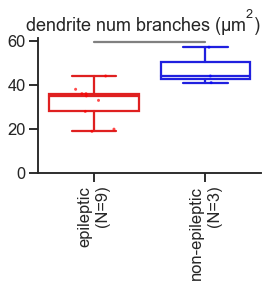

In [241]:
feat = ['basal_dendrite_num_branches',]
labels = [feature_name(x) for x in feat]
labels[0] += ' ($μm^2$)'

utils.plot_boxplot_multiple(data, feat, group_col, labels=labels, test='mannwhitney', figsize=(4,2.5), pairs='all',
                          palette=epilepsy_palette )
save_plot_multiple(figdir/"s6_medical_morph_mtg_only", ['svg'])

### Interaction

In [155]:
data = human_df.query("l1_type & has_morph")
data = human_df.query("l1_type & has_morph & cortical_lobe=='TemL'")
data = human_df.query("l1_type & has_morph & structure=='MTG'")
groups='homology_type'
compare='epileptic'
data.groupby(groups)[compare].value_counts(dropna=False)

homology_type  epileptic    
LAMP5          epileptic        9
               non-epileptic    3
MC4R           epileptic        2
               non-epileptic    2
PAX6           non-epileptic    5
               epileptic        4
L1 VIP         epileptic        3
other          epileptic        2
               non-epileptic    1
Name: epileptic, dtype: int64

In [156]:
features = morph_features
res = utils.run_species_subclass_stats(data, features, compare=compare, group_var=groups, anova_type=1, 
                                       compare_first=False, )
res.head()

/local1/storage/envs/ipfx38/lib/python3.8/site-packages/statsmodels/base/model.py:1863: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 8
  warnings.warn('covariance of constraints does not have full '
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/statsmodels/base/model.py:1863: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 8
  warnings.warn('covariance of constraints does not have full '
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/statsmodels/base/model.py:1863: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 8
  warnings.warn('covariance of constraints does not have full '
/local1/storage/envs/ipfx38/lib/python3.8/site-packages/statsmodels/base/model.py:1863: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 8
  warnings.w

,eta_p_epileptic,pval_epileptic,pval_homology_type:epileptic,rsquared,interaction,sig_groups,PAX6,LAMP5,other,MC4R,auc_PAX6,auc_LAMP5,auc_other,auc_MC4R
feature,,,,,,,,,,,,,,
basal_dendrite_frac_above_axon,0.781795,5.121490e-07,2.867884e-09,0.962423,True,,0.502335,1.0,0.666667,0.220671,0.6,0.5,1.0,1.0
basal_dendrite_extent_x,0.361223,4.835711e-02,2.830287e-01,0.704734,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
basal_dendrite_total_surface_area,0.210480,4.103209e-01,3.612079e-01,0.589174,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
basal_dendrite_num_branches,0.173903,5.435197e-01,4.631526e-01,0.452340,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
basal_dendrite_total_length,0.148659,6.403938e-01,4.631526e-01,0.503211,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [159]:
data = human_df.query("l1_type & has_morph")
groups='reconstruction_type'
compare='epileptic'
data.groupby(groups)[compare].value_counts(dropna=False)

reconstruction_type  epileptic    
100x                 non-epileptic     8
                     epileptic         2
63x                  epileptic        37
                     non-epileptic    24
Name: epileptic, dtype: int64

In [160]:
features = morph_features
res = utils.run_species_subclass_stats(data, features, compare=compare, group_var=groups, anova_type=1, 
                                       compare_first=False, )
res.head()

,eta_p_epileptic,pval_epileptic,pval_reconstruction_type:epileptic,rsquared,interaction
feature,,,,,
basal_dendrite_num_branches,0.222050,0.001946,0.949218,0.246959,False
basal_dendrite_total_surface_area,0.209639,0.001946,0.949218,0.215649,False
basal_dendrite_total_length,0.158604,0.011923,0.949218,0.184147,False
basal_dendrite_mean_diameter,0.126476,0.034553,0.949218,0.207922,False
axon_frac_above_basal_dendrite,0.112954,0.048472,0.949218,0.117151,False


In [166]:
data = human_df.query("l1_type & has_morph & cortical_lobe!='ParL' & cortical_lobe!='OccL'")
groups='cortical_lobe'
compare='epileptic'
data.groupby(groups)[compare].value_counts(dropna=False)

cortical_lobe  epileptic    
FroL           non-epileptic    12
               epileptic         1
TemL           epileptic        37
               non-epileptic    15
Name: epileptic, dtype: int64

In [167]:
res = utils.run_species_subclass_stats(data, features, compare=compare, group_var=groups, anova_type=1, 
                                       compare_first=False, )
res.head()

,eta_p_epileptic,pval_epileptic,pval_cortical_lobe:epileptic,rsquared,interaction
feature,,,,,
basal_dendrite_extent_x,0.250759,0.001488,0.748543,0.281000,False
basal_dendrite_total_surface_area,0.227559,0.001970,0.858994,0.233298,False
basal_dendrite_total_length,0.192369,0.005502,0.986110,0.193048,False
basal_dendrite_max_euclidean_distance,0.155736,0.017488,0.907430,0.201228,False
basal_dendrite_frac_above_axon,0.143302,0.022635,0.782517,0.158679,False


## cytoarchitecture

In [127]:
donors = lims.get_donor_info(species='Homo Sapiens')
donors = donors[donors.name.str.startswith('H') & donors.name.str.contains('.')]
donors.index = donors.name.apply(lambda x: x.split('.')[-1])

donors['condition'] = donors['medical_condition'].map(condition)
donors['epileptic'] = donors['medical_condition'].map(epileptic)

In [128]:
donor_ids = data.id.unique()
donor_specimens = lims.get_cells_df(donors_list=donor_ids)
donor_specimens.head()

,name,created_at,pin_z,normalized_depth,soma_depth_um,structure,hemisphere,donor_name,donor_age,donor_sex,species,dendrite_type,img_status,layer,project_code,err_id,nwb_path,nwb_type,reconstruction_tag,reconstruction_type,swc_path
id,,,,,,,,,,,,,,,,,,,,,
839221899,H19.29.144.11.42.02,2019-03-19 21:04:50.417628,99.0,None,None,MTG,right,H19.29.144,65 yrs,F,Homo Sapiens,None,63x imaging started,Layer 3,hIVSCC-METx,NaN,None,None,None,None,None
839222460,H19.29.144.11.42.03,2019-03-19 21:06:08.702233,99.0,None,None,MTG,right,H19.29.144,65 yrs,F,Homo Sapiens,None,63x imaging started,Layer 1,hIVSCC-METx,NaN,None,None,None,63x,/allen/programs/celltypes/production/humancell...
839222712,H19.29.144.11.31.01,2019-03-19 21:07:26.632787,99.0,None,None,MTG,right,H19.29.144,65 yrs,F,Homo Sapiens,None,None,None,hIVSCC-METx,NaN,None,None,None,None,None
839223070,H19.29.144.11.32.01,2019-03-19 21:08:37.476130,99.0,None,None,MTG,right,H19.29.144,65 yrs,F,Homo Sapiens,None,None,None,hIVSCC-METx,NaN,None,None,None,None,None
839223651,H19.29.144.11.32.02,2019-03-19 21:10:37.873106,99.0,None,None,MTG,right,H19.29.144,65 yrs,F,Homo Sapiens,None,None,None,hIVSCC-METx,NaN,None,None,None,None,None


In [129]:
cyto_df = pd.read_csv("../data/Source data cortical structure L1.csv")
cyto_df.columns = [x.replace(' um', ' µm') for x in cyto_df.columns]

cyto_human = cyto_df.query("Species=='human '").copy()
cyto_human['donor'] = cyto_human['Human subject nr/mouse nr'].astype(str)

In [130]:
data = cyto_human.join(donors, on='donor')

group_col = 'condition'
data[group_col].value_counts(dropna=False)

epilepsy    37
tumor       34
NaN         28
Name: condition, dtype: int64

In [131]:
donor_areas = donor_specimens.groupby('donor_name')['structure'].apply(
    lambda df: ', '.join(list(df.dropna().unique()))).map(lobe)
data = data.join(donor_areas, on='name')

In [132]:
pd.crosstab(data[group_col], data['structure'])

structure,Occ/FroL,TemL
condition,,
epilepsy,2,28
tumor,3,23


In [133]:
features = [ 'L1 thickness, µm', 'L1 Neuron Density',
       'Cell Soma Area, µm', 'Neuron Count in 1 mm wide ROI of L1']
res = utils.run_twosamp(data, features, group_col, fdr_method='fdr_bh')
res

,pval_mw,mw_r,roc_auc,pval_t,cohens_d,nobs,pval_t_fdr,pval_mw_fdr
feature,,,,,,,,
"L1 thickness, µm",5.054932e-07,0.694754,0.847377,0.000009,1.061171,71,0.000036,0.000002
"Cell Soma Area, µm",9.398552e-02,0.232114,0.616057,0.029465,0.475251,71,0.039287,0.177433
L1 Neuron Density,1.330751e-01,0.208267,0.604134,0.023943,0.487160,71,0.039287,0.177433
Neuron Count in 1 mm wide ROI of L1,2.426904e-01,0.162162,0.581081,0.450411,0.166378,71,0.450411,0.242690


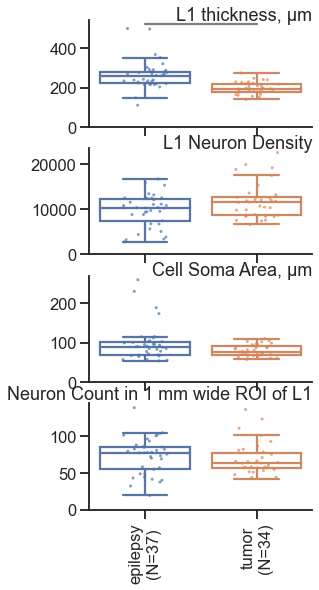

In [79]:
feat = features
utils.plot_boxplot_multiple(data, feat, group_col, labels=feature_name, test='mannwhitney', figsize=(4,9))

In [137]:
# holds at the donor level also
group_means = data.groupby(['donor', group_col])[features].mean().reset_index()
res = utils.run_twosamp(group_means, features, group_col, fdr_method='fdr_bh')
res

,pval_mw,mw_r,roc_auc,pval_t,cohens_d,nobs,pval_t_fdr,pval_mw_fdr
feature,,,,,,,,
"L1 thickness, µm",0.002331,0.918367,0.959184,0.036791,1.122409,14,0.087063,0.009324
L1 Neuron Density,0.072844,0.591837,0.795918,0.043531,1.091417,14,0.087063,0.145688
"Cell Soma Area, µm",0.534965,0.224490,0.612245,0.362030,0.527705,14,0.463557,0.710373
Neuron Count in 1 mm wide ROI of L1,0.710373,0.142857,0.571429,0.463557,0.427069,14,0.463557,0.710373


### mouse comparison

In [124]:
data['group'] = "human " + data['condition']
data_species = pd.concat([data, cyto_df.query("Species=='mouse'").assign(group='mouse')], sort=False)

In [121]:
reload(utils)

<module 'patchseq_utils.analysis' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/analysis.py'>

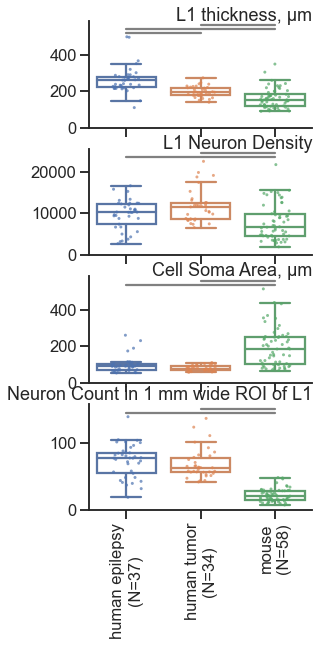

In [125]:
feat = features
utils.plot_boxplot_multiple(data_species, feat, 'group', labels=feature_name, test='mannwhitney', figsize=(4,9))

# sex

## ephys

In [262]:
data = human_df.query("l1_type & collaborator=='AIBS' & failed_fx_long_squares==False")
group_col = 'sex'
data[group_col].value_counts(dropna=False)

M    129
F     65
Name: sex, dtype: int64

In [263]:
features = subset_features(data, ephys_features, complete_frac=0.4)
res = utils.run_twosamp(data, features, group_col, fdr_method='fdr_bh')
# res.to_csv(figdir/'supp_tables'/'md_sex_ephys.csv')
md_sex_ephys = res
res.head(20)

,pval_mw,mw_r,roc_auc,pval_t,cohens_d,nobs,pval_t_fdr,pval_mw_fdr
feature,,,,,,,,
rheobase_i,0.015896,0.208945,0.604472,0.017807,0.360133,194,0.819136,0.995677
tau,0.048277,0.174001,0.587001,0.014765,0.370383,194,0.819136,0.995677
low_freq_impedance_chirp,0.062488,0.248718,0.624359,0.633693,0.110879,82,0.996616,0.995677
sag_peak_t_depol,0.082717,0.166294,0.583147,0.082678,0.287783,171,0.996616,0.995677
threshold_i_ramp,0.100423,0.144952,0.572476,0.179527,0.205278,193,0.996616,0.995677
peak_impedance_chirp,0.100715,0.219231,0.609615,0.271260,0.255193,82,0.996616,0.995677
avg_rate_hero,0.110991,0.140370,0.570185,0.237959,0.180342,194,0.996616,0.995677
fi_fit_slope,0.127883,0.134168,0.567084,0.309680,0.155320,194,0.996616,0.995677
width_ramp,0.129845,0.133654,0.566827,0.260263,0.172296,193,0.996616,0.995677


In [268]:
reload(utils)

<module 'patchseq_utils.analysis' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/analysis.py'>

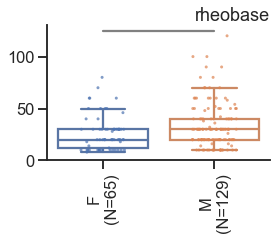

In [270]:
fig, ax = plt.subplots( figsize=(4,2.5))
utils.plot_box_cluster_feature(data, 'rheobase_i', group_col, label='rheobase',
                               test='mannwhitney', ax=ax, label_align='center')
save_plot_multiple(figdir/"s6_sex", ['svg'])

## morpho

In [271]:
data = human_df.query("l1_type & has_morph & condition!='hydrocephalus'")
group_col = 'sex'
data[group_col].value_counts(dropna=False)

M    38
F    31
Name: sex, dtype: int64

In [272]:
features = morph_features
res = utils.run_twosamp(data, features, group_col, fdr_method='fdr_bh')
# res.to_csv(figdir/'supp_tables'/'md_sex_morph.csv')
md_sex_morph = res
res.head()

,pval_mw,mw_r,roc_auc,pval_t,cohens_d,nobs,pval_t_fdr,pval_mw_fdr
feature,,,,,,,,
axon_total_length,0.130038,0.213922,0.606961,0.079774,0.426968,69,0.948797,0.966927
axon_depth_pc_4,0.156352,0.200340,0.600170,0.078649,0.428534,69,0.948797,0.966927
axon_soma_percentile_y,0.163523,0.196944,0.598472,0.119807,0.380023,69,0.948797,0.966927
axon_mean_contraction,0.167200,0.195246,0.597623,0.391759,0.210550,69,0.948797,0.966927
basal_dendrite_soma_percentile_x,0.170939,0.193548,0.596774,0.350451,0.229430,69,0.948797,0.966927


# age

## ephys

In [273]:
human_df['age_years'] = human_df['age'].map(lambda x: np.nan if x=='unknown' else int(x.split(' ')[0]))

In [301]:
data = human_df.query("l1_type & collaborator=='AIBS' & failed_fx_long_squares==False")


In [302]:
group_col = 'age_years'
features = subset_features(data, ephys_features, complete_frac=0.4)
res = utils.run_correlations(data, features, group_col, fdr_method='fdr_bh')
# res.to_csv(figdir/'supp_tables'/'md_age_ephys.csv')
md_age_ephys = res
res.head(20)

,r,pval,pval_fdr
feature,,,
peak_deltav_hero,-0.174015,0.015782,0.450650
peak_v_hero,-0.146983,0.041910,0.450650
upstroke_rheo,-0.131764,0.068485,0.450650
postap_slope_ramp,0.129669,0.073800,0.450650
peak_deltav_short_square,-0.124830,0.086157,0.450650
sag_area,0.120928,0.094757,0.450650
peak_v_rheo,-0.117660,0.104089,0.450650
peak_deltav_rheo,-0.115889,0.109440,0.450650
avg_rate_hero,0.112954,0.118782,0.450650


In [303]:
corr = data[features].corr(method='spearman')
feat = utils.select_distinct(res[res.pval<0.05].index, corr, nfeat=4, threshold=0.7)
feat

['peak_deltav_hero']

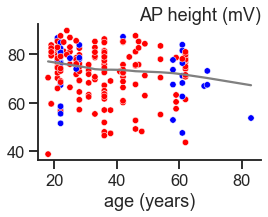

In [309]:

utils.plot_boxplot_multiple(data, feat, group_col, labels=['AP height (mV)'],
                            plot_function=utils.plot_spearman, 
                            figsize=(4,2.5), stats=False, size=4, 
                            hue='epileptic', palette=epilepsy_palette)
plt.xlabel('age (years)')
save_plot_multiple(figdir/"s6_age_ephys", ['svg'])

## morpho

In [310]:
# data = human_df.query("l1_type & has_morph & condition!='hydrocephalus'")
data = human_df.query("l1_type & has_morph")

In [291]:
group_col = 'age_years'
features = morph_features
res = utils.run_correlations(data, features, group_col, fdr_method='fdr_bh')
# res.to_csv(figdir/'supp_tables'/'md_age_morph.csv')
md_age_morph = res
res.head(20)

,r,pval,pval_fdr
feature,,,
axon_bias_y,-0.272390,0.021556,0.265996
axon_exit_distance,-0.259903,0.028606,0.265996
axon_depth_pc_4,-0.258156,0.029732,0.265996
basal_dendrite_total_length,0.250517,0.035105,0.265996
basal_dendrite_total_surface_area,0.246798,0.037999,0.265996
axon_depth_pc_0,-0.229956,0.053707,0.313293
basal_dendrite_num_branches,0.215825,0.070659,0.353296
axon_max_branch_order,-0.190238,0.112045,0.490195
axon_total_length,-0.166944,0.164070,0.499745


In [292]:
corr = data[features].corr(method='spearman')
feat = utils.select_distinct(res[res.pval<0.05].index, corr, nfeat=4, threshold=0.7)
feat

['axon_bias_y',
 'axon_exit_distance',
 'axon_depth_pc_4',
 'basal_dendrite_total_length']

In [295]:
reload(utils)

<module 'patchseq_utils.analysis' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/analysis.py'>

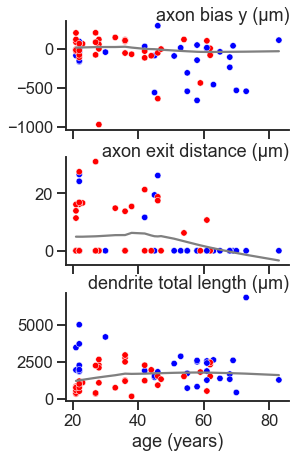

In [311]:
feat = ['axon_bias_y',
 'axon_exit_distance',
 'basal_dendrite_total_length']
labels = [feature_name(x)+' (μm)' for x in feat]
utils.plot_boxplot_multiple(data, feat, group_col, labels=labels,
                            plot_function=utils.plot_spearman, 
                            figsize=(4,7), stats=False, size=4, 
                            hue='epileptic', palette=epilepsy_palette)
plt.xlabel('age (years)')
save_plot_multiple(figdir/"s6_age_morph", ['svg'])

In [333]:
with pd.ExcelWriter(figdir/'supp_tables'/'data_S3_metadata_effect_statistics.xlsx') as writer: 
    md_region_ephys.to_excel(writer, sheet_name='Brain region ~ electrophysiology effects')
    md_region_morpho.to_excel(writer, sheet_name='Brain region ~ morphology effects')
    md_medical_ephys.to_excel(writer, sheet_name='Medical condition ~ electrophysiology effects')
    md_medical_morpho.to_excel(writer, sheet_name='Medical condition ~ morphology effects')
    md_sex_ephys.to_excel(writer, sheet_name='Sex ~ electrophysiology effects')
    md_sex_morph.to_excel(writer, sheet_name='Sex ~ morphology effects')
    md_age_ephys.to_excel(writer, sheet_name='Age ~ electrophysiology effects')
    md_age_morph.to_excel(writer, sheet_name='Age ~ morphology effects')

/local1/storage/envs/ipfx38/lib/python3.8/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
